In [1]:
import numpy as np
import os
import warnings
import pandas as pd
import scipy.interpolate as scintrp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import savgol_filter as smooth

import foam
import windPlotters as wPlt
import wind

In [2]:
dir_wtVl_tngE2 = r"D:/tempData_depot/simData_CandC/wt_tngE2/"
inflowDir_E2 = dir_wtVl_tngE2+r"inflow/"

lScl=0.02
H = 0.08

# Load the target wind field

In [3]:
dt_cobraProbe = 6.2500e-04

temp = pd.read_csv(dir_wtVl_tngE2+"profiles.csv")
U_TH = np.load(dir_wtVl_tngE2+"UofT.npy")
V_TH = np.load(dir_wtVl_tngE2+"VofT.npy")
W_TH = np.load(dir_wtVl_tngE2+"WofT.npy")
wtVel_E2 = wind.profile(name="BLWT-E2", Z=temp.Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt_cobraProbe,nSpectAvg=16)

# U_TH = V_TH = W_TH = None

esdu74_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu85_E2 = wind.ESDU85(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))


## Scale the cobra probe data to avg. HFPI test speeds

The current profile data has already been scaled in Matlab. The cobra probe $U_h$ was around 7 $m/s$.

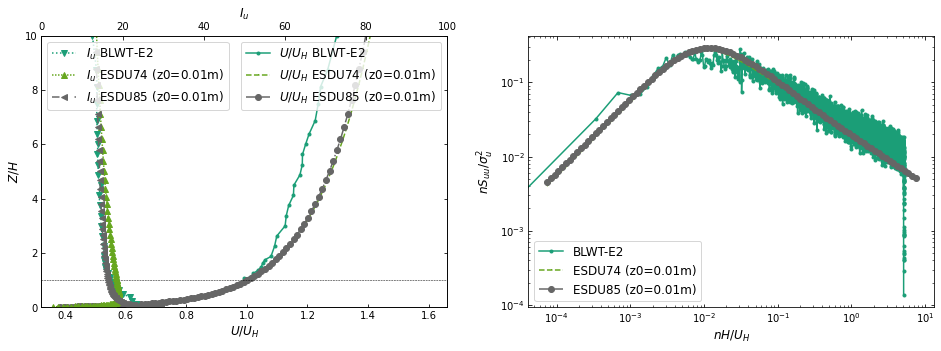

In [4]:

velE2 = wind.Profiles([wtVel_E2, esdu74_E2.toProfileObj(), esdu85_E2.toProfileObj()])
velE2.plot(fig=plt.figure(figsize=[16,5]), zLim=[0,10])

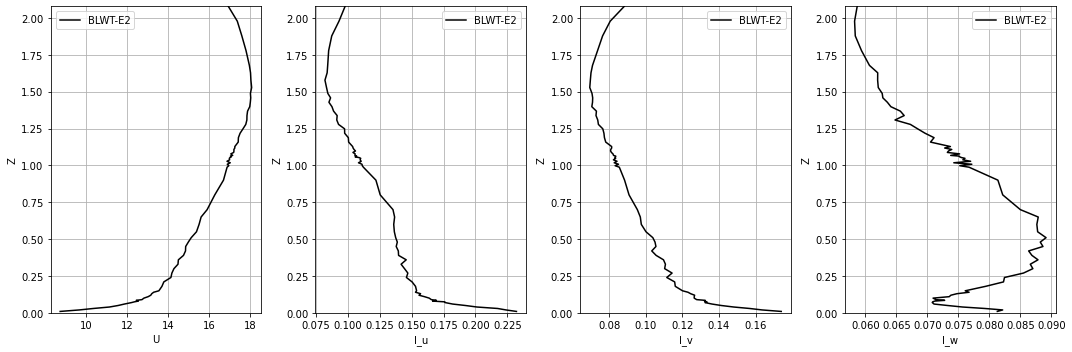

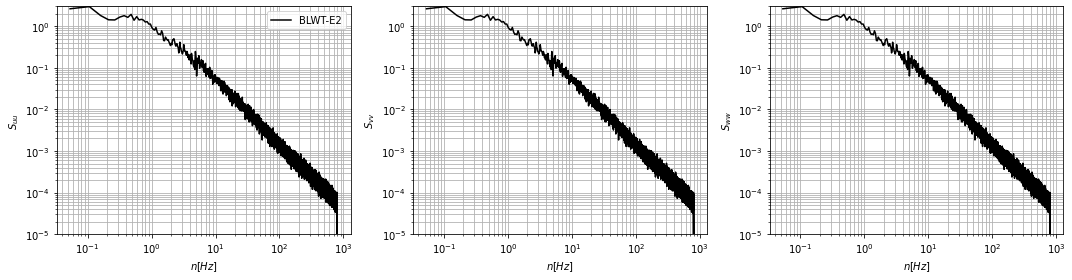

In [5]:
wtVel_E2.plotProfiles(figSize=[15,5])

ylim = [1e-5,3e0]
wtVel_E2.SpectH.plotSpectra(figSize=[15,4],normalize=False,yLimits=(ylim,ylim,ylim))

# Extract smoothed data

In [6]:
def exp_mov_avg(x, alpha):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i-1]
    return y

def mov_avg(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def smooth(data, window_length, polyorder):
    from scipy.signal import savgol_filter
    smoothed_data = savgol_filter(data, window_length=window_length, polyorder=polyorder)
    return smoothed_data


In [7]:
sIdx = 0
eIdx = np.argmin(np.abs(wtVel_E2.Z - 1.5))+1
s = 19

Z = np.array(wtVel_E2.Z[sIdx:eIdx])
U = smooth(wtVel_E2.U, 9, 3)[sIdx:eIdx]
Iu = smooth(wtVel_E2.Iu, 9, 3)[sIdx:eIdx]
Iv = smooth(wtVel_E2.Iv, 9, 3)[sIdx:eIdx]
Iw = smooth(wtVel_E2.Iw, 9, 3)[sIdx:eIdx]
Lu = smooth(wtVel_E2.xLu, 21, 2)[sIdx:eIdx]
Lv = smooth(wtVel_E2.xLv, 21, 2)[sIdx:eIdx]
Lw = smooth(wtVel_E2.xLw, 21, 2)[sIdx:eIdx]

prof = pd.DataFrame()
prof['Z'] = Z.tolist()
prof['U'] = U.tolist()
prof['Iu'] = Iu.tolist()
prof['Iv'] = Iv.tolist()
prof['Iw'] = Iw.tolist()
prof['Lu'] = Lu.tolist()
prof['Lv'] = Lv.tolist()
prof['Lw'] = Lw.tolist()

print(prof)

prof_orig = prof

           Z          U        Iu        Iv        Iw        Lu        Lv  \
0   0.009906   8.723768  0.232967  0.173851  0.082013  1.089010  0.564253   
1   0.020066   9.666392  0.223707  0.164401  0.080942  1.180255  0.613750   
2   0.029972  10.437106  0.213567  0.155702  0.078912  1.266539  0.658584   
3   0.039878  11.055121  0.203167  0.147995  0.076371  1.347860  0.698755   
4   0.050038  11.539651  0.193122  0.141518  0.073770  1.424220  0.734262   
..       ...        ...       ...       ...       ...       ...       ...   
59  1.367790  17.909243  0.088940  0.072023  0.064873  1.393836  0.559448   
60  1.398016  17.938422  0.087985  0.071663  0.064340  1.352027  0.555959   
61  1.427988  17.979732  0.086746  0.071044  0.063831  1.306398  0.552121   
62  1.457960  18.016690  0.085208  0.070526  0.062943  1.281816  0.550560   
63  1.487932  18.037951  0.084357  0.070059  0.062569  1.261346  0.548825   

          Lw  
0   0.031039  
1   0.043442  
2   0.056444  
3   0.070045  


In [8]:
from scipy.signal import welch

def spect(data,fs,n=8,olFact=0.5,pad=False, window = 'hann'):
    N = len(data)
    # Define the parameters for the Welch method
    
    n_perseg = N//n  # Set nperseg to a larger value
    n_overlap = int(np.ceil(n_perseg * olFact))
    n_fft = max(n_perseg, 256)  # Ensure nfft is at least as large as nperseg

    # Compute the power spectral density using Welch's method
    freq, psd = welch(data, fs=fs, window=window, nperseg=n_perseg, noverlap=n_overlap, nfft=n_fft)
    return freq, psd


In [9]:
def spectSmooth(data, fs):
    freq_lf, psd_lf = spect(data, fs, n=2, olFact=0.1)
    freq_hf, psd_hf = spect(data, fs, n=1000, olFact=0.9)

    idx_lf = np.logspace(np.log10(1.5), np.log10(1000), 25, dtype=int)
    idx_lf[0] = 0
    idx_hf = 3
    
    psd_lf_smth = smooth(psd_lf, 301, 1)

    freq = np.concatenate([freq_lf[idx_lf], freq_hf[idx_hf:]])
    psd = np.concatenate([psd_lf_smth[idx_lf], psd_hf[idx_hf:]])
    return freq, psd, freq_lf, psd_lf, freq_hf, psd_hf

In [10]:
sIdx = 0
eIdx = np.argmin(np.abs(wtVel_E2.Z - 1.5))+1
fs = wtVel_E2.samplingFreq

Suu = Svv = Sww = np.array([])
for i in range(sIdx,eIdx):
    z = wtVel_E2.Z[i]
    
    freq, psd_u, freq_lf, psd_lf_u, freq_hf, psd_hf_u = spectSmooth(wtVel_E2.UofT[i,:], fs)
    _, psd_v, _, psd_lf_v, _, psd_hf_v = spectSmooth(wtVel_E2.VofT[i,:], fs)
    _, psd_w, _, psd_lf_w, _, psd_hf_w = spectSmooth(wtVel_E2.WofT[i,:], fs)
    if i == 0:
        Suu, Svv, Sww = psd_u, psd_v, psd_w
        Suu_lf, Svv_lf, Sww_lf = psd_lf_u, psd_lf_v, psd_lf_w
        Suu_hf, Svv_hf, Sww_hf = psd_hf_u, psd_hf_v, psd_hf_w
    else:
        Suu = np.vstack((Suu, psd_u))
        Svv = np.vstack((Svv, psd_v))
        Sww = np.vstack((Sww, psd_w))
        Suu_lf = np.vstack((Suu_lf, psd_lf_u))
        Svv_lf = np.vstack((Svv_lf, psd_lf_v))
        Sww_lf = np.vstack((Sww_lf, psd_lf_w))
        Suu_hf = np.vstack((Suu_hf, psd_hf_u))
        Svv_hf = np.vstack((Svv_hf, psd_hf_v))
        Sww_hf = np.vstack((Sww_hf, psd_hf_w))

    
    print(f"z = {z}, \tfreq: {np.shape(freq)}\t psd: {np.shape(psd_u)}\t Suu: {np.shape(Suu)}\t Svv: {np.shape(Svv)}\t Sww: {np.shape(Sww)}")

Suu = np.transpose(Suu)
Svv = np.transpose(Svv)
Sww = np.transpose(Sww)
Suu_lf = np.transpose(Suu_lf)
Svv_lf = np.transpose(Svv_lf)
Sww_lf = np.transpose(Sww_lf)
Suu_hf = np.transpose(Suu_hf)
Svv_hf = np.transpose(Svv_hf)
Sww_hf = np.transpose(Sww_hf)

Suu_orig = Suu
Svv_orig = Svv
Sww_orig = Sww

z = 0.009906, 	freq: (263,)	 psd: (263,)	 Suu: (263,)	 Svv: (263,)	 Sww: (263,)
z = 0.020066, 	freq: (263,)	 psd: (263,)	 Suu: (2, 263)	 Svv: (2, 263)	 Sww: (2, 263)
z = 0.029972, 	freq: (263,)	 psd: (263,)	 Suu: (3, 263)	 Svv: (3, 263)	 Sww: (3, 263)
z = 0.039878, 	freq: (263,)	 psd: (263,)	 Suu: (4, 263)	 Svv: (4, 263)	 Sww: (4, 263)
z = 0.050038, 	freq: (263,)	 psd: (263,)	 Suu: (5, 263)	 Svv: (5, 263)	 Sww: (5, 263)
z = 0.059944, 	freq: (263,)	 psd: (263,)	 Suu: (6, 263)	 Svv: (6, 263)	 Sww: (6, 263)
z = 0.070104, 	freq: (263,)	 psd: (263,)	 Suu: (7, 263)	 Svv: (7, 263)	 Sww: (7, 263)
z = 0.07493, 	freq: (263,)	 psd: (263,)	 Suu: (8, 263)	 Svv: (8, 263)	 Sww: (8, 263)
z = 0.08001, 	freq: (263,)	 psd: (263,)	 Suu: (9, 263)	 Svv: (9, 263)	 Sww: (9, 263)
z = 0.08509, 	freq: (263,)	 psd: (263,)	 Suu: (10, 263)	 Svv: (10, 263)	 Sww: (10, 263)
z = 0.089916, 	freq: (263,)	 psd: (263,)	 Suu: (11, 263)	 Svv: (11, 263)	 Sww: (11, 263)
z = 0.100076, 	freq: (263,)	 psd: (263,)	 Suu: (12, 263)	

## Append near ground point

In [11]:
prof = prof_orig
zg = 0.000001
scl = 0.1
grnd = pd.Series({'Z': zg, 
                  'U': prof.U[0]*scl,
                  'Iu': prof.Iu[0]*scl,
                  'Iv': prof.Iv[0]*scl,
                  'Iw': prof.Iw[0]*scl,
                  'Lu': prof.Lu[0]*scl,
                  'Lv': prof.Lv[0]*scl,
                  'Lw': prof.Lw[0]*scl,
                  })
prof.loc[-1] = grnd
prof.index = prof.index + 1
prof.sort_index(inplace=True)
print(prof)

Suu = Suu_orig
Svv = Svv_orig
Sww = Sww_orig

print(np.shape(Suu))

Suu = np.append(Suu[:,0,np.newaxis]*scl, Suu, axis=1)
Svv = np.append(Svv[:,0,np.newaxis]*scl, Svv, axis=1)
Sww = np.append(Sww[:,0,np.newaxis]*scl, Sww, axis=1)

print(np.shape(Suu))

           Z          U        Iu        Iv        Iw        Lu        Lv  \
0   0.000001   0.872377  0.023297  0.017385  0.008201  0.108901  0.056425   
1   0.009906   8.723768  0.232967  0.173851  0.082013  1.089010  0.564253   
2   0.020066   9.666392  0.223707  0.164401  0.080942  1.180255  0.613750   
3   0.029972  10.437106  0.213567  0.155702  0.078912  1.266539  0.658584   
4   0.039878  11.055121  0.203167  0.147995  0.076371  1.347860  0.698755   
..       ...        ...       ...       ...       ...       ...       ...   
60  1.367790  17.909243  0.088940  0.072023  0.064873  1.393836  0.559448   
61  1.398016  17.938422  0.087985  0.071663  0.064340  1.352027  0.555959   
62  1.427988  17.979732  0.086746  0.071044  0.063831  1.306398  0.552121   
63  1.457960  18.016690  0.085208  0.070526  0.062943  1.281816  0.550560   
64  1.487932  18.037951  0.084357  0.070059  0.062569  1.261346  0.548825   

          Lw  
0   0.003104  
1   0.031039  
2   0.043442  
3   0.056444  


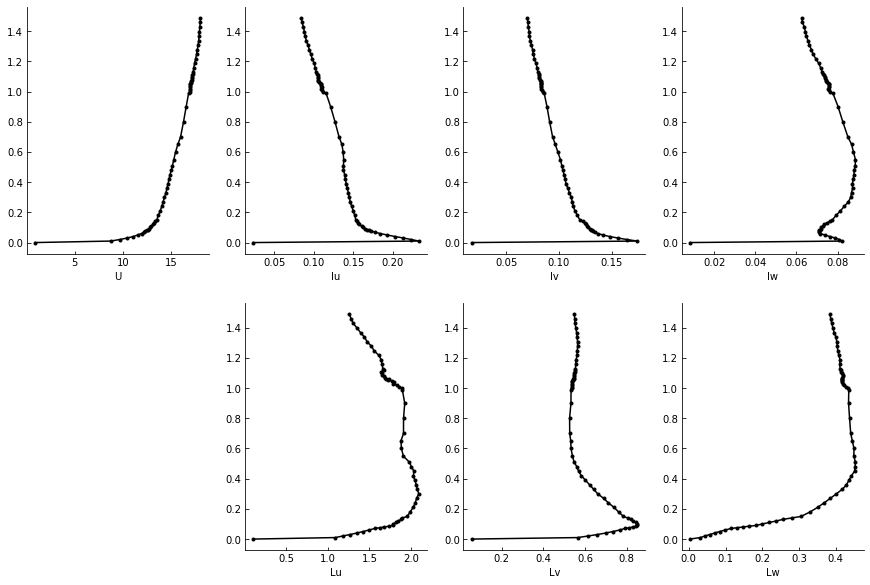

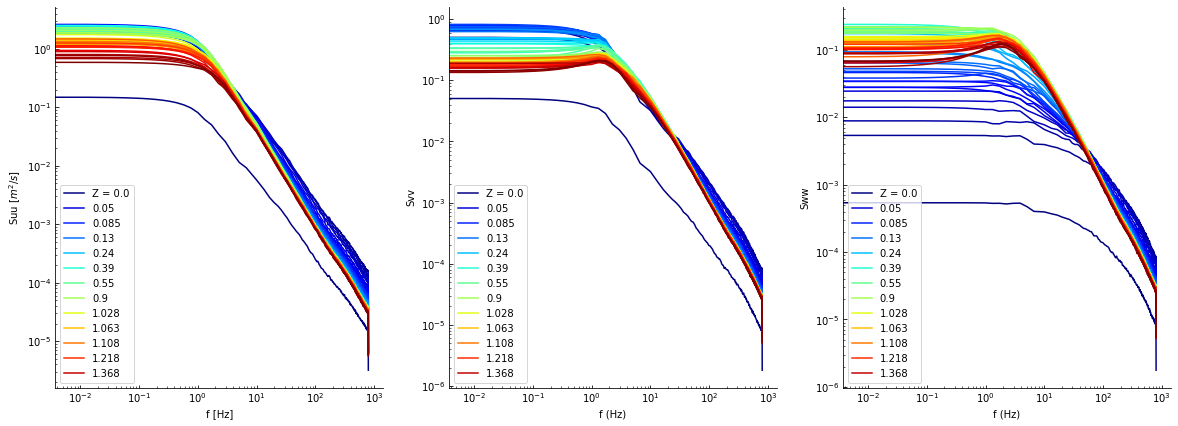

In [12]:
# import matplotlib.colors as mcolors
import matplotlib.cm as cm

def commonSettings(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in',which='both')

plt.figure(figsize=[15,10])

ax = plt.subplot(2,4,1)
plt.plot(prof.U, prof.Z, '-k.')
plt.xlabel('U')
commonSettings(ax)

ax = plt.subplot(2,4,2)
plt.plot(prof.Iu, prof.Z, '-k.')
plt.xlabel('Iu')
commonSettings(ax)

ax = plt.subplot(2,4,3)
plt.plot(prof.Iv, prof.Z, '-k.')
plt.xlabel('Iv')
commonSettings(ax)

ax = plt.subplot(2,4,4)
plt.plot(prof.Iw, prof.Z, '-k.')
plt.xlabel('Iw')
commonSettings(ax)

ax = plt.subplot(2,4,6)
plt.plot(prof.Lu, prof.Z, '-k.')
plt.xlabel('Lu')
commonSettings(ax)

ax = plt.subplot(2,4,7)
plt.plot(prof.Lv, prof.Z, '-k.')
plt.xlabel('Lv')
commonSettings(ax)

ax = plt.subplot(2,4,8)
plt.plot(prof.Lw, prof.Z, '-k.')
plt.xlabel('Lw')
commonSettings(ax)

plt.show()

plt.figure(figsize=[20,7])

N = len(prof.Z)
colors = cm.jet(np.linspace(0, 1, N))
# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors, N=N)

# i = 0
# plt.loglog(freq_lf, Suu_lf[:,i],'-k.')
# plt.loglog(freq_hf, Suu_hf[:,i],'-r.')

ax = plt.subplot(1,3,1)
lns = []
for i in range(N):
    if i%5 == 0:
        lbl = 'Z = '+str(np.round(prof.Z[i],3)) if len(lns) == 0 else str(np.round(prof.Z[i],3))
        ln, = plt.loglog(freq, Suu[:,i],'-',color=colors[i],label=lbl)
        lns.append(ln)
    else:
        plt.loglog(freq, Suu[:,i],'-',color=colors[i],label=str(np.round(prof.Z[i],3)))
commonSettings(ax)
plt.xlabel(r'f [Hz]')
plt.ylabel(r'Suu $[m^2/s]$')
plt.legend(handles=lns)

ax = plt.subplot(1,3,2)
lns = []
for i in range(N):
    if i%5 == 0:
        lbl = 'Z = '+str(np.round(prof.Z[i],3)) if len(lns) == 0 else str(np.round(prof.Z[i],3))
        ln, = plt.loglog(freq, Svv[:,i],'-',color=colors[i],label=lbl)
        lns.append(ln)
    else:
        plt.loglog(freq, Svv[:,i],'-',color=colors[i],label=str(np.round(prof.Z[i],3)))
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Svv')
plt.legend(handles=lns)


ax = plt.subplot(1,3,3)
lns = []
for i in range(N):
    if i%5 == 0:
        lbl = 'Z = '+str(np.round(prof.Z[i],3)) if len(lns) == 0 else str(np.round(prof.Z[i],3))
        ln, = plt.loglog(freq, Sww[:,i],'-',color=colors[i],label=lbl)
        lns.append(ln)
    else:
        plt.loglog(freq, Sww[:,i],'-',color=colors[i],label=str(np.round(prof.Z[i],3)))
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Sww')
plt.legend(handles=lns)

plt.show()

# Write to file

In [13]:
print(wtVel_E2.Uh)

12.54255496736732


In [14]:
# print(f"writing to: {inflowDir_E2}")
# prof.to_csv(inflowDir_E2+'profile',sep=' ',index=None,header=None)

# temp = pd.DataFrame(prof.Z.tolist())
# temp.to_csv(inflowDir_E2+'spect_z',sep=' ',index=None,header=None)

# temp = pd.DataFrame(freq.tolist())
# temp.to_csv(inflowDir_E2+'spect_f',sep=' ',index=None,header=None)

# temp = pd.DataFrame(Suu)
# temp.to_csv(inflowDir_E2+'Suu',sep=' ',index=None,header=None)
# temp = pd.DataFrame(Svv)
# temp.to_csv(inflowDir_E2+'Svv',sep=' ',index=None,header=None)
# temp = pd.DataFrame(Sww)
# temp.to_csv(inflowDir_E2+'Sww',sep=' ',index=None,header=None)

# with open(inflowDir_E2+'samplingPoints', 'a') as the_file:
#     the_file.write(str(len(prof.Z))+'\n(\n')
#     for z in prof.Z:
#         the_file.write('(0.0 0.0 '+str(z)+')\n')
#     the_file.write(');\n')

# From ESDU best fit

In [15]:
# outdir = inflowDir_E2+'esdu/'
# es = wind.ESDU85()

# lscl = 0.01
# tscl = 0.1
# vscl = lscl/tscl

# n = np.logspace(-4.5,2,150)
# Z = es.Z
# temp = pd.DataFrame(Z)*lscl
# temp.to_csv(outdir+'spect_z',sep=' ',index=None,header=None)
# temp = pd.DataFrame(n)/tscl
# temp.to_csv(outdir+'spect_f',sep=' ',index=None,header=None)

# Nz = len(Z)
# Nf = len(n)

# Suu = Svv = Sww = np.empty((Nf,0))
# Suu_vonK = Svv_vonK = Sww_vonK = np.empty((Nf,0))

# for i, zi in enumerate(Z):
#     _, Su = es.Suu(n=n, Z=zi)
#     Suu = np.append(Suu, np.reshape(Su,(-1,1)), axis=1)
#     Su = wind.vonKarmanSuu(n=n, U=es.U(Z=zi),Iu=es.Iu(Z=zi),xLu=es.xLu(Z=zi))
#     Suu_vonK = np.append(Suu_vonK, np.reshape(Su,(-1,1)), axis=1)

#     _, Sv = es.Svv(n=n, Z=zi)
#     Svv = np.append(Svv, np.reshape(Sv,(-1,1)), axis=1)
#     Sv = wind.vonKarmanSvv(n=n, U=es.U(Z=zi),Iv=es.Iv(Z=zi),xLv=es.xLv(Z=zi))
#     Svv_vonK = np.append(Svv_vonK, np.reshape(Sv,(-1,1)), axis=1)

#     _, Sw = es.Sww(n=n, Z=zi)
#     Sww = np.append(Sww, np.reshape(Sw,(-1,1)), axis=1)
#     Sw = wind.vonKarmanSww(n=n, U=es.U(Z=zi),Iw=es.Iw(Z=zi),xLw=es.xLw(Z=zi))
#     Sww_vonK = np.append(Sww_vonK, np.reshape(Sw,(-1,1)), axis=1)


# temp = pd.DataFrame(Suu)*(lscl**2/tscl)
# temp.to_csv(outdir+'Suu',sep=' ',index=None,header=None)
# temp = pd.DataFrame(Svv)*(lscl**2/tscl)
# temp.to_csv(outdir+'Svv',sep=' ',index=None,header=None)
# temp = pd.DataFrame(Sww)*(lscl**2/tscl)
# temp.to_csv(outdir+'Sww',sep=' ',index=None,header=None)

# temp = pd.DataFrame(Suu_vonK)*(lscl**2/tscl)
# temp.to_csv(outdir+'Suu_vonK',sep=' ',index=None,header=None)
# temp = pd.DataFrame(Svv_vonK)*(lscl**2/tscl)
# temp.to_csv(outdir+'Svv_vonK',sep=' ',index=None,header=None)
# temp = pd.DataFrame(Sww_vonK)*(lscl**2/tscl)
# temp.to_csv(outdir+'Sww_vonK',sep=' ',index=None,header=None)

# temp = pd.DataFrame()
# temp['Z'] = (es.Z*lscl).tolist()
# temp['U'] = (es.U()*vscl).tolist()
# temp['Iu'] = es.Iu().tolist()
# temp['Iv'] = es.Iv().tolist()
# temp['Iw'] = es.Iw().tolist()
# temp['Lu'] = (es.xLu()*lscl).tolist()
# temp['Lv'] = (es.xLv()*lscl).tolist()
# temp['Lw'] = (es.xLw()*lscl).tolist()
# temp.to_csv(outdir+'profile',sep=' ',index=None,header=None)


# plt.figure()
# # plt.plot(es.U(), es.Z)
# plt.loglog(n ,Sww[:,50],label='ESDU')
# plt.loglog(n ,Sww_vonK[:,50],label='vonK')
# # plt.loglog(n ,Svv[:,50])
# # plt.loglog(n ,Svv)
# # plt.loglog(n ,Sww)
# # plt.xlim([0,5e-5])
# plt.legend()
# plt.show()

# Inflow with DFSR 

## Trial 1: with BLWT data as input 

In [16]:
sampleName = 'sampledData_inflow1'
readFromFile = False
if readFromFile:
    probes, time, UofT = foam.__readProbe_singleT(inflowDir_E2+sampleName+'/Ux','p')
    print('Finished reading UofT')
    _, _, VofT = foam.__readProbe_singleT(inflowDir_E2+sampleName+'/Uy','p')
    print('Finished reading VofT')
    _, _, WofT = foam.__readProbe_singleT(inflowDir_E2+sampleName+'/Uz','p')
    print('Finished reading WofT')

    UofT = np.transpose(UofT)
    VofT = np.transpose(VofT)
    WofT = np.transpose(WofT)

    np.save(inflowDir_E2+sampleName+'/time.npy',time)
    np.save(inflowDir_E2+sampleName+'/probes.npy',probes)
    np.save(inflowDir_E2+sampleName+'/UofT.npy',UofT)
    np.save(inflowDir_E2+sampleName+'/VofT.npy',VofT)
    np.save(inflowDir_E2+sampleName+'/WofT.npy',WofT)
else:
    time = np.load(inflowDir_E2+sampleName+'/time.npy')
    probes = np.load(inflowDir_E2+sampleName+'/probes.npy')
    UofT = np.load(inflowDir_E2+sampleName+'/UofT.npy')
    VofT = np.load(inflowDir_E2+sampleName+'/VofT.npy')
    WofT = np.load(inflowDir_E2+sampleName+'/WofT.npy')

dt = time[2] - time[1]

dfsr_E2 = wind.profile(name="DFSR-E2", Z=probes[:,2], UofT=UofT, VofT=VofT, WofT=WofT, H=H, dt=dt, nSpectAvg=32)

vel_E2 = wind.Profiles([wtVel_E2, dfsr_E2])

In [17]:
# nProbes = 64

# UofT = pd.read_csv(inflowDir_E2+'sampledData/Ux', delimiter='\t', skiprows=nProbes+1)
# T = UofT['#Time '].tolist()
# UofT = UofT.drop(UofT.columns[0], axis=1)
# UofT = UofT.drop(UofT.columns[-1], axis=1)

# VofT = pd.read_csv(inflowDir_E2+'sampledData/Uy', delimiter='\t', skiprows=nProbes+1)
# VofT = VofT.drop(VofT.columns[0], axis=1)
# VofT = VofT.drop(VofT.columns[-1], axis=1)

# WofT = pd.read_csv(inflowDir_E2+'sampledData/Uz', delimiter='\t', skiprows=nProbes+1)
# WofT = WofT.drop(WofT.columns[0], axis=1)
# WofT = WofT.drop(WofT.columns[-1], axis=1)

# UofT = np.transpose(UofT.to_numpy())
# VofT = np.transpose(VofT.to_numpy())
# WofT = np.transpose(WofT.to_numpy())

# dt = T[2] - T[1]

# dfsr_E2 = wind.profile(name="DFSR-E2", Z=prof.Z, UofT=UofT[:,:22000], VofT=VofT[:,:22000], WofT=WofT[:,:22000], H=H, dt=dt, nSpectAvg=16)
dfsr_E2 = wind.profile(name="DFSR-E2", Z=dfsr_E2.Z, UofT=UofT, VofT=VofT, WofT=WofT, H=H, dt=dt, nSpectAvg=64)

# vel_E2 = wind.Profiles([wtVel_E2, dfsr_E2])

# print(WofT.columns[-1])
# print(np.shape(prof.Z))


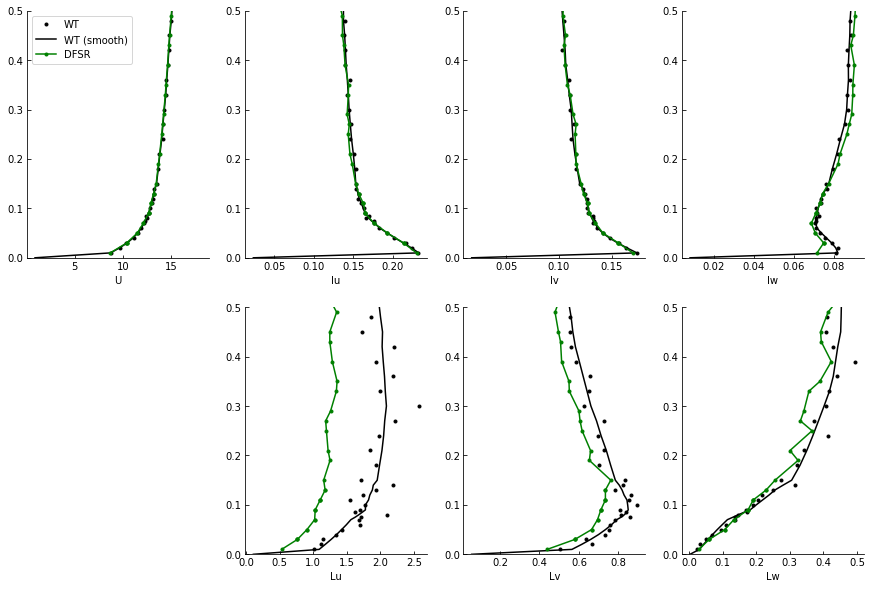

In [18]:

def commonSettings(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in',which='both')
    ax.set_ylim([0, 0.5])

plt.figure(figsize=[15,10])

ax = plt.subplot(2,4,1)
plt.plot(wtVel_E2.U, wtVel_E2.Z, '.k', label='WT')
plt.plot(prof.U, prof.Z, '-k', label='WT (smooth)')
plt.plot(dfsr_E2.U, dfsr_E2.Z, '-g.', label='DFSR')
plt.xlabel('U')
plt.legend()
commonSettings(ax)

ax = plt.subplot(2,4,2)
plt.plot(wtVel_E2.Iu, wtVel_E2.Z, '.k', label='WT')
plt.plot(prof.Iu, prof.Z, '-k', label='WT (smooth)')
plt.plot(dfsr_E2.Iu, dfsr_E2.Z, '-g.', label='DFSR')
plt.xlabel('Iu')
commonSettings(ax)

ax = plt.subplot(2,4,3)
plt.plot(wtVel_E2.Iv, wtVel_E2.Z, '.k', label='WT')
plt.plot(prof.Iv, prof.Z, '-k', label='WT (smooth)')
plt.plot(dfsr_E2.Iv, dfsr_E2.Z, '-g.', label='DFSR')
plt.xlabel('Iv')
commonSettings(ax)

ax = plt.subplot(2,4,4)
plt.plot(wtVel_E2.Iw, wtVel_E2.Z, '.k', label='WT')
plt.plot(prof.Iw, prof.Z, '-k', label='WT (smooth)')
plt.plot(dfsr_E2.Iw, dfsr_E2.Z, '-g.', label='DFSR')
plt.xlabel('Iw')
commonSettings(ax)

# ax = plt.subplot(2,4,5)
# plt.plot(wtVel_E2.uv, wtVel_E2.Z, '.k', label=wtVel_E2.name)
# # plt.plot(prof.Iw, prof.Z, '-k', label='WT (smooth)')
# plt.plot(dfsr_E2.uv, dfsr_E2.Z, '-g.', label='DFSR')
# plt.xlabel("u'w'")
# commonSettings(ax)

ax = plt.subplot(2,4,6)
plt.plot(wtVel_E2.xLu, wtVel_E2.Z, '.k', label='WT')
plt.plot(prof.Lu, prof.Z, '-k', label='WT (smooth)')
plt.plot(dfsr_E2.xLu, dfsr_E2.Z, '-g.', label='DFSR')
plt.xlabel('Lu')
commonSettings(ax)

ax = plt.subplot(2,4,7)
plt.plot(wtVel_E2.xLv, wtVel_E2.Z, '.k', label='WT')
plt.plot(prof.Lv, prof.Z, '-k', label='WT (smooth)')
plt.plot(dfsr_E2.xLv, dfsr_E2.Z, '-g.', label='DFSR')
plt.xlabel('Lv')
commonSettings(ax)

ax = plt.subplot(2,4,8)
plt.plot(wtVel_E2.xLw, wtVel_E2.Z, '.k', label='WT')
plt.plot(prof.Lw, prof.Z, '-k', label='WT (smooth)')
plt.plot(dfsr_E2.xLw, dfsr_E2.Z, '-g.', label='DFSR')
plt.xlabel('Lw')
commonSettings(ax)

plt.show()


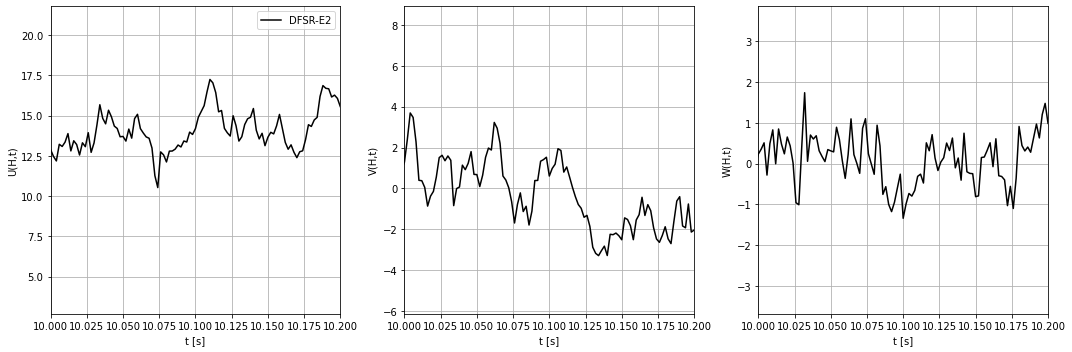

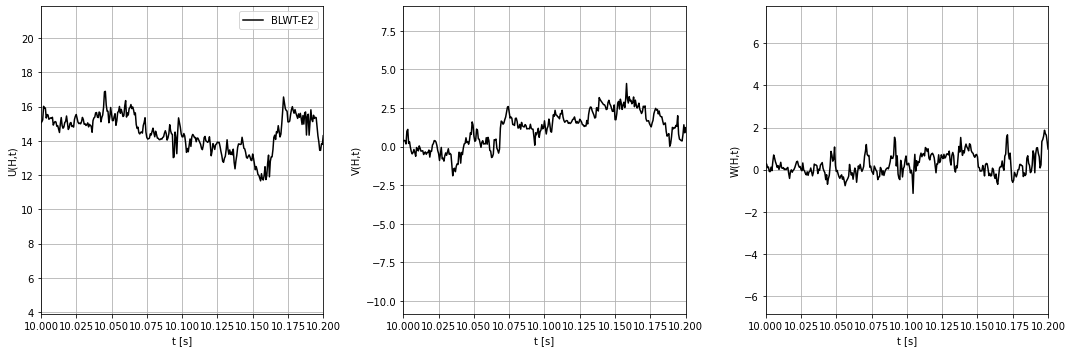

In [19]:
dfsr_E2.plotTimeHistory(xLimits=[10, 10.2])
wtVel_E2.plotTimeHistory(xLimits=[10, 10.2])

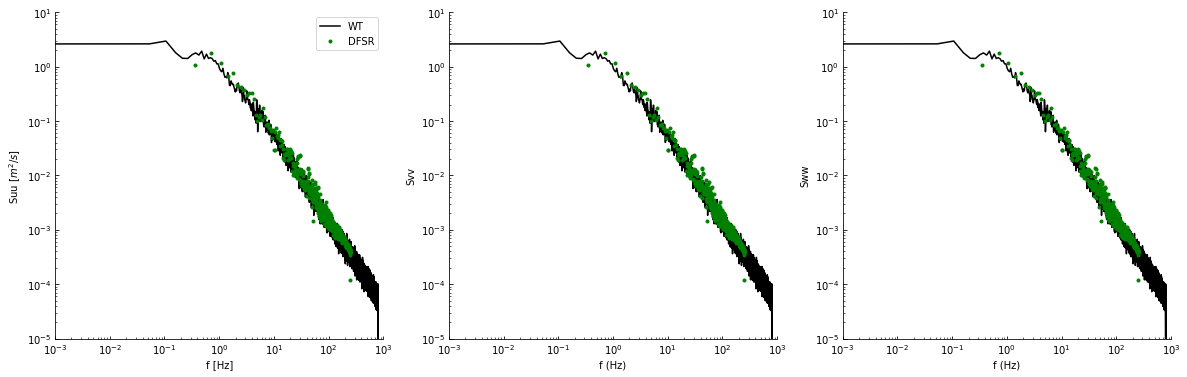

In [20]:
def commonSettings(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in',which='both')
    ax.set_xlim([1e-3, 1e3])
    ax.set_ylim([1e-5, 1e1])

plt.figure(figsize=[20,6])

N = len(prof.Z)
colors = cm.jet(np.linspace(0, 1, N))
# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors, N=N)



ax = plt.subplot(1,3,1)
plt.loglog(wtVel_E2.SpectH.n, wtVel_E2.SpectH.Suu, '-k', label='WT')
plt.loglog(dfsr_E2.SpectH.n, dfsr_E2.SpectH.Suu, '.g', label='DFSR')
commonSettings(ax)
plt.xlabel(r'f [Hz]')
plt.ylabel(r'Suu $[m^2/s]$')
plt.legend()

ax = plt.subplot(1,3,2)
plt.loglog(wtVel_E2.SpectH.n, wtVel_E2.SpectH.Svv, '-k')
plt.loglog(dfsr_E2.SpectH.n, dfsr_E2.SpectH.Svv, '.g')
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Svv')

ax = plt.subplot(1,3,3)
plt.loglog(wtVel_E2.SpectH.n, wtVel_E2.SpectH.Sww, '-k')
plt.loglog(dfsr_E2.SpectH.n, dfsr_E2.SpectH.Sww, '.g')
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Sww')

plt.show()

### Mesh size design for incoming flow region

The mesh size in the incident region is estimated as: $$\delta=\sqrt{\frac{\pi}{n_c}F(n_c)}$$
$F(n_c)=S_{uu}(n_c)+S_{vv}(n_c)+S_{ww}(n_c)$, <br>
$n_c=\frac{f_{MK}U_h}{H}=\frac{2U_h}{H}$

In [21]:
Uh = wtVel_E2.Uh
f_MK = 2.0
n_c = f_MK*Uh/H

i_z = np.argmin(np.abs(prof.Z - H))
print(f"H = {prof.Z[i_z]} m")
print(f"Uh = {Uh} m/s")

i_f = np.argmin(np.abs(freq - n_c))
print(f"n_c = {n_c} Hz, n_c(closest) = {freq[i_f]} Hz")

F_nc = Suu[i_f,i_z] + Svv[i_f,i_z] + Sww[i_f,i_z]
print(f"F(nc) = {F_nc} m^2/s")

delta = np.sqrt(np.pi*F_nc/n_c)
print(f"delta = {delta} m")

H = 0.08001 m
Uh = 12.54255496736732 m/s
n_c = 313.56387418418296 Hz, n_c(closest) = 313.33333333333337 Hz
F(nc) = 0.000742240952674801 m^2/s
delta = 0.0027269952521805072 m


Basics for blockMesh definition

In [22]:
x0 = -1.0
x1 = 1.6
y0 = -0.64
y1 = 0.64
z0 = 0.0
z1 = 1.0

nLevels = 3

deltaBase = delta * np.power(2, nLevels)

Nx = int(np.round((x1-x0)/deltaBase, 0))
Ny = int(np.round((y1-y0)/deltaBase, 0))
Nz = int(np.round((z1-z0)/deltaBase, 0))

print(f"deltaBase = {deltaBase} m")
print(f"Nx = {Nx}")
print(f"Ny = {Ny}")
print(f"Nz = {Nz}")

deltaBase = 0.021815962017444058 m
Nx = 119
Ny = 59
Nz = 46


### Empty domain outputs

In [23]:
lesDir = dir_wtVl_tngE2 + 'tngE2.1/'


In [24]:
les = []

# probeName = 'sampler.zProfile_x-3.5Hy0.probes'
# les_1 = foam.processVelProfile(lesDir,probeName=probeName,name="LES_v1(x=-3.5H)",exportPlots=False, trimTimeSegs=[[0,1.0]],H=H)
# les.append(les_1)

probeName = 'sampler.zProfile_x0y0.probes'
les_x0 = foam.processVelProfile(lesDir,probeName=probeName,name="LES_v1(x=0)",exportPlots=False, trimTimeSegs=[[0,1.0]],H=H)
les.append(les_x0)

# probeName = 'sampler.zProfile_x10Hy0.probes'
# les_1 = foam.processVelProfile(lesDir,probeName=probeName,name="LES_v1(x=10H)",exportPlots=False, trimTimeSegs=[[0,1.0]],H=H)
# les.append(les_1)

Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2/tngE2.1/
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2/tngE2.1//postProcessing/sampler.zProfile_x0y0.probes
Target profile read from:	None
  >> Reading probe data ...
             << Done!
  >> Processing profile data.
             << Done!
  >> Writing data to file.
             << Done!
  >> Finished reading probe data.


In [25]:
print(wtVel_E2.IuH)
print(dfsr_E2.IuH)
print(les_x0.IuH)

0.1664879607937308
0.1762120976213458
0.1908277623561064


In [26]:
def plotProfiles(prof:wind.Profiles, zMax=0.5, TIlim=[0, 0.5], 
                 col=['r','k','b','g','m','c',],
                 mrk=['s','.','+','v','d','<',],
                 lst=['-','-','-','-','-','-',]):
    def commonSettings(ax):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(direction='in',which='both')
        ax.set_ylim([0, zMax])

    plt.figure(figsize=[15,10])

    ax = plt.subplot(2,4,1)
    for i,p in enumerate(prof):
        plt.plot(p.U, p.Z, color=col[i], linestyle=lst[i], marker=mrk[i], label=p.name)
    plt.xlabel('U')
    plt.legend()
    commonSettings(ax)

    ax = plt.subplot(2,4,2)
    for i,p in enumerate(prof):
        plt.plot(p.Iu, p.Z, color=col[i], linestyle=lst[i], marker=mrk[i], label=p.name)
    plt.xlabel('Iu')
    plt.xlim(TIlim)
    commonSettings(ax)

    ax = plt.subplot(2,4,3)
    for i,p in enumerate(prof):
        plt.plot(p.Iv, p.Z, color=col[i], linestyle=lst[i], marker=mrk[i], label=p.name)
    plt.xlabel('Iv')
    plt.xlim(TIlim)
    commonSettings(ax)

    ax = plt.subplot(2,4,4)
    for i,p in enumerate(prof):
        plt.plot(p.Iw, p.Z, color=col[i], linestyle=lst[i], marker=mrk[i], label=p.name)
    plt.xlabel('Iw')
    plt.xlim(TIlim)
    commonSettings(ax)

    # ax = plt.subplot(2,4,5)
    # plt.plot(wtVel_E2.uv, wtVel_E2.Z, '.k', label=wtVel_E2.name)
    # # plt.plot(prof.Iw, prof.Z, '-k', label='WT (smooth)')
    # plt.plot(dfsr_E2.uv, dfsr_E2.Z, '-r.', label='DFSR')
    # plt.xlabel("u'w'")
    # commonSettings(ax)

    ax = plt.subplot(2,4,6)
    for i,p in enumerate(prof):
        plt.plot(p.xLu, p.Z, color=col[i], linestyle=lst[i], marker=mrk[i], label=p.name)
    plt.xlabel('Lu')
    commonSettings(ax)

    ax = plt.subplot(2,4,7)
    for i,p in enumerate(prof):
        plt.plot(p.xLv, p.Z, color=col[i], linestyle=lst[i], marker=mrk[i], label=p.name)
    plt.xlabel('Lv')
    commonSettings(ax)

    ax = plt.subplot(2,4,8)
    for i,p in enumerate(prof):
        plt.plot(p.xLw, p.Z, color=col[i], linestyle=lst[i], marker=mrk[i], label=p.name)
    plt.xlabel('Lw')
    commonSettings(ax)

    plt.show()

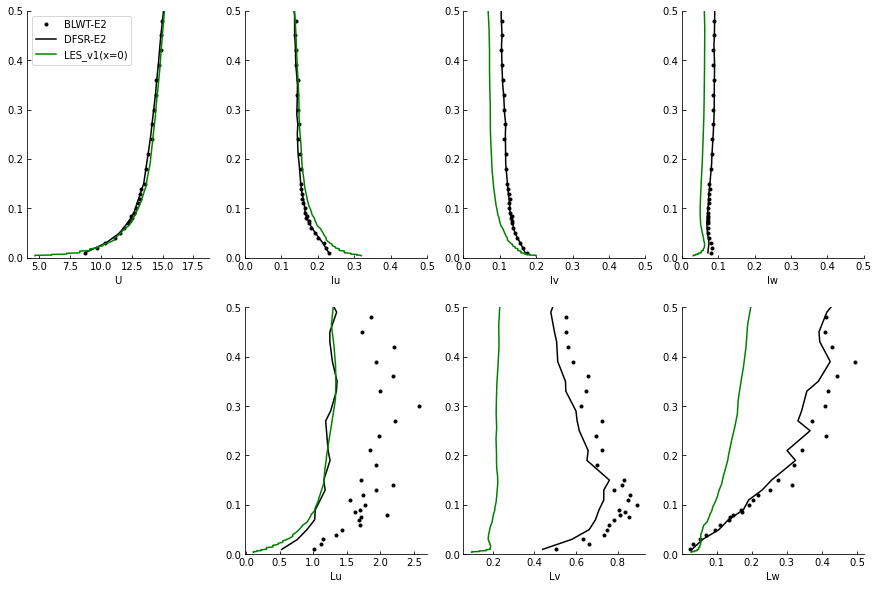

In [27]:
# plotProfiles(wtVel_E2,prof, dfsr_E2,les)
plotProfiles(wind.Profiles([wtVel_E2, dfsr_E2,les[0]]), zMax=0.5,
             col=['k','k','g','r'],
             mrk=['.','None','None','None'],
             lst=['None','-','-','-'])

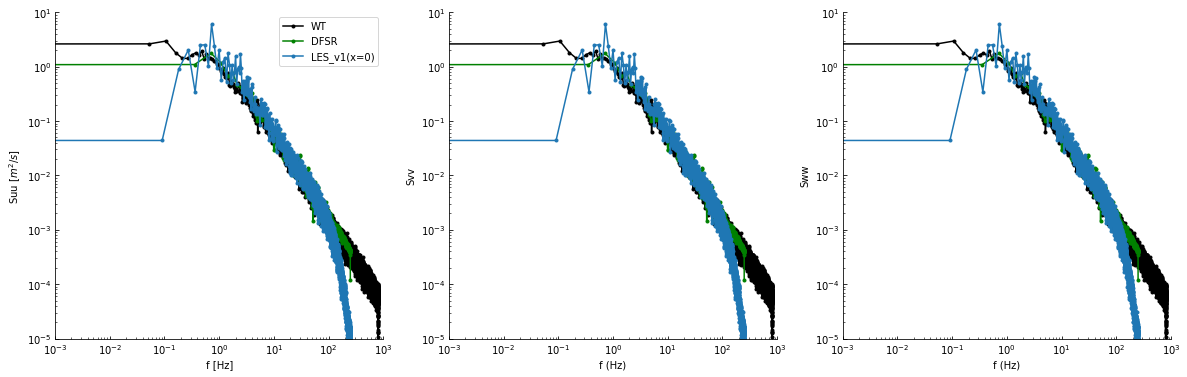

In [28]:
def commonSettings(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in',which='both')
    ax.set_xlim([1e-3, 1e3])
    ax.set_ylim([1e-5, 1e1])

plt.figure(figsize=[20,6])

N = len(prof.Z)
colors = cm.jet(np.linspace(0, 1, N))
# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors, N=N)



ax = plt.subplot(1,3,1)
plt.loglog(wtVel_E2.SpectH.n, wtVel_E2.SpectH.Suu, '.k-', label='WT')
plt.loglog(dfsr_E2.SpectH.n, dfsr_E2.SpectH.Suu, '.g-', label='DFSR')
for l in les:
    plt.loglog(l.SpectH.n, l.SpectH.Suu, '.-', label=l.name)
commonSettings(ax)
plt.xlabel(r'f [Hz]')
plt.ylabel(r'Suu $[m^2/s]$')
plt.legend()

ax = plt.subplot(1,3,2)
plt.loglog(wtVel_E2.SpectH.n, wtVel_E2.SpectH.Svv, '.k-')
plt.loglog(dfsr_E2.SpectH.n, dfsr_E2.SpectH.Svv, '.g-')
for l in les:
    plt.loglog(l.SpectH.n, l.SpectH.Svv, '.-', label=l.name)
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Svv')

ax = plt.subplot(1,3,3)
plt.loglog(wtVel_E2.SpectH.n, wtVel_E2.SpectH.Sww, '.k-')
plt.loglog(dfsr_E2.SpectH.n, dfsr_E2.SpectH.Sww, '.g-')
for l in les:
    plt.loglog(l.SpectH.n, l.SpectH.Sww, '.-', label=l.name)
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Sww')

plt.show()

In [29]:
rSuu = wtVel_E2.SpectH.rf()
print(np.shape(rSuu))

(15009,)


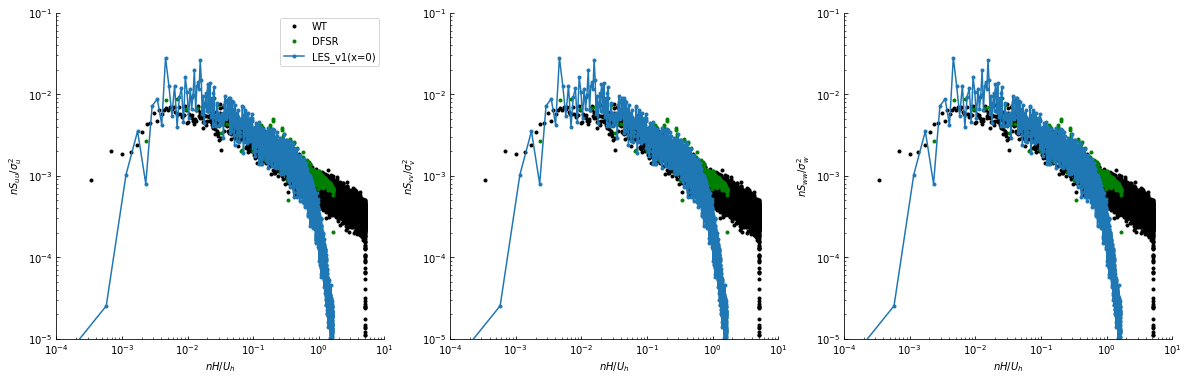

In [30]:
def commonSettings(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in',which='both')
    ax.set_xlim([1e-4, 10])
    ax.set_ylim([1e-5, 0.1])

plt.figure(figsize=[20,6])

N = len(prof.Z)
colors = cm.jet(np.linspace(0, 1, N))
# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors, N=N)



ax = plt.subplot(1,3,1)
plt.loglog(wtVel_E2.SpectH.rf(), wtVel_E2.SpectH.rSuu(), '.k', label='WT')
plt.loglog(dfsr_E2.SpectH.rf(), dfsr_E2.SpectH.rSuu(), '.g', label='DFSR')
for l in les:
    plt.loglog(l.SpectH.rf(), l.SpectH.rSuu(), '.-', label=l.name)
commonSettings(ax)
plt.xlabel(r'$nH/U_h$')
plt.ylabel(r'$nS_{uu}/\sigma_u^2$')
plt.legend()

ax = plt.subplot(1,3,2)
plt.loglog(wtVel_E2.SpectH.rf(), wtVel_E2.SpectH.rSvv(), '.k')
plt.loglog(dfsr_E2.SpectH.rf(), dfsr_E2.SpectH.rSvv(), '.g')
for l in les:
    plt.loglog(l.SpectH.rf(), l.SpectH.rSvv(), '.-', label=l.name)
commonSettings(ax)
plt.xlabel(r'$nH/U_h$')
plt.ylabel(r'$nS_{vv}/\sigma_v^2$')

ax = plt.subplot(1,3,3)
plt.loglog(wtVel_E2.SpectH.rf(), wtVel_E2.SpectH.rSww(), '.k')
plt.loglog(dfsr_E2.SpectH.rf(), dfsr_E2.SpectH.rSww(), '.g')
for l in les:
    plt.loglog(l.SpectH.rf(), l.SpectH.rSww(), '.-', label=l.name)
commonSettings(ax)
plt.xlabel(r'$nH/U_h$')
plt.ylabel(r'$nS_{ww}/\sigma_w^2$')

plt.show()

# Trial 2: scaled from Trial 1

Observations from Trial 1:
* $v$ and $w$ components of both TI and integral length scales are significantly decayed.
* The fetch distance has the most effect on $I_w$ close to the ground
* A slight overestimation of $I_u$ around to roof-height ($z=H=0.08m$).

Changes in Trial 2:
* Scale up $I_u$, $I_v$, $I_w$, $^xL_u$, $^xL_v$, $^xL_w$ with the ratio between the final LES output and the original BLWT input.

Observations from Trial 1:
* $^xL_u$ is greatly underestimated. $^xL_v$ and $^xL_w$ are also slightly underestimated.
* Duration plays important role to match TI.

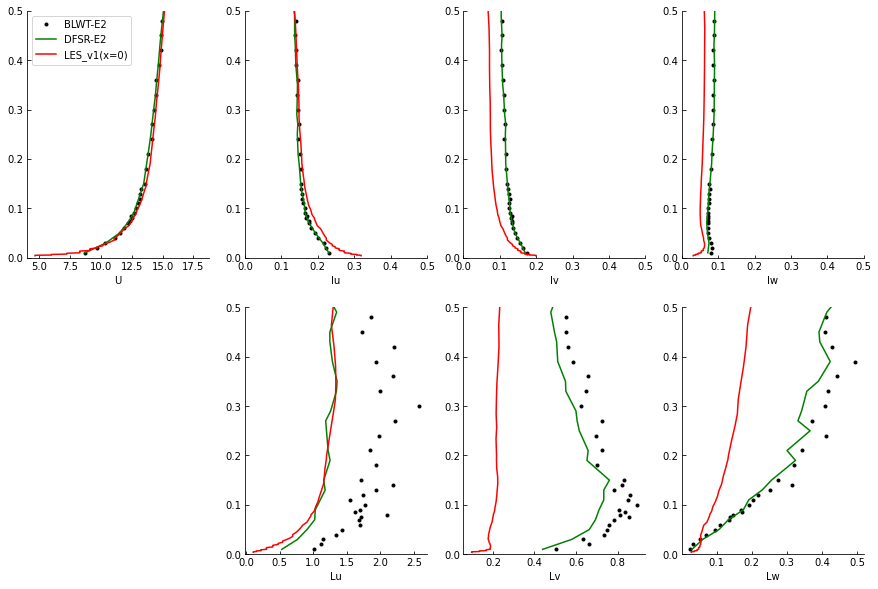

In [31]:

# plotProfiles(wtVel_E2,prof, dfsr_E2,les, zMax=1.5)

plotProfiles(wind.Profiles([wtVel_E2, dfsr_E2,les_x0]), zMax=0.5,
             col=['k','g','r'],
             mrk=['.','None','None','None'],
             lst=['None','-','-','-'])

(0.0, 0.3)

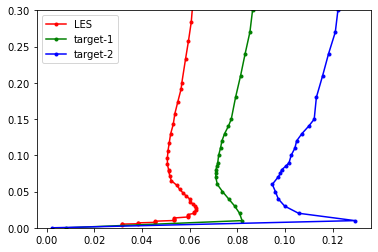

In [32]:
eIdx = np.argmin(np.abs(prof.Z - les_x0.Z[-1])) -2

prof_les = prof.copy()
prof_les.U  = np.interp(prof_les.Z, les_x0.Z, les_x0.U)
prof_les.Iu = np.interp(prof_les.Z, les_x0.Z, les_x0.Iu)
prof_les.Iv = np.interp(prof_les.Z, les_x0.Z, les_x0.Iv)
prof_les.Iw = np.interp(prof_les.Z, les_x0.Z, les_x0.Iw)
prof_les.Lu = np.interp(prof_les.Z, les_x0.Z, les_x0.xLu)
prof_les.Lv = np.interp(prof_les.Z, les_x0.Z, les_x0.xLv)
prof_les.Lw = np.interp(prof_les.Z, les_x0.Z, les_x0.xLw)

sclFctr_1 = prof.copy()
sclFctr_1.loc[:, ~sclFctr_1.columns.isin(['Z'])] = 1.0

prof2 = prof.copy()

clmns = ['U', 'Iu', 'Iv', 'Iw', 'Lu', 'Lv', 'Lw']
for c in clmns:
    sclFctr_1.loc[:eIdx, c] = prof.loc[:eIdx, c] / prof_les.loc[:eIdx, c]
    sclFctr_1.loc[eIdx:, c] = sclFctr_1.loc[eIdx, c]
    prof2.loc[:,c] = smooth((prof.loc[:,c] * sclFctr_1.loc[:,c]), 5, 4)


plt.figure()
plt.plot(les_x0.Iw, les_x0.Z, '.r-', label='LES')
plt.plot(prof.Iw, prof.Z, '.g-', label='target-1')
plt.plot(prof2.Iw, prof2.Z, '.b-', label='target-2')
plt.legend()
plt.ylim([0, 0.3])

In [33]:
print(np.shape(Suu))
print(np.shape(prof2))
print(inflowDir_E2)

Suu_2 = Suu.copy()
Svv_2 = Svv.copy()
Sww_2 = Sww.copy()

scl = smooth((sclFctr_1.Iu.to_numpy()**2)*sclFctr_1.U.to_numpy(), 5, 4)
Suu_2 = np.multiply(Suu_2, scl)

scl = smooth((sclFctr_1.Iv.to_numpy()**2)*sclFctr_1.U.to_numpy(), 5, 4)
Svv_2 = np.multiply(Svv_2, scl)

scl = smooth((sclFctr_1.Iw.to_numpy()**2)*sclFctr_1.U.to_numpy(), 5, 4)
Sww_2 = np.multiply(Sww_2, scl)

print(Suu[5,3])
print(Suu_2[5,3])

(263, 65)
(65, 8)
D:/tempData_depot/simData_CandC/wt_tngE2/inflow/
2.200586244133309
1.8281548204873652


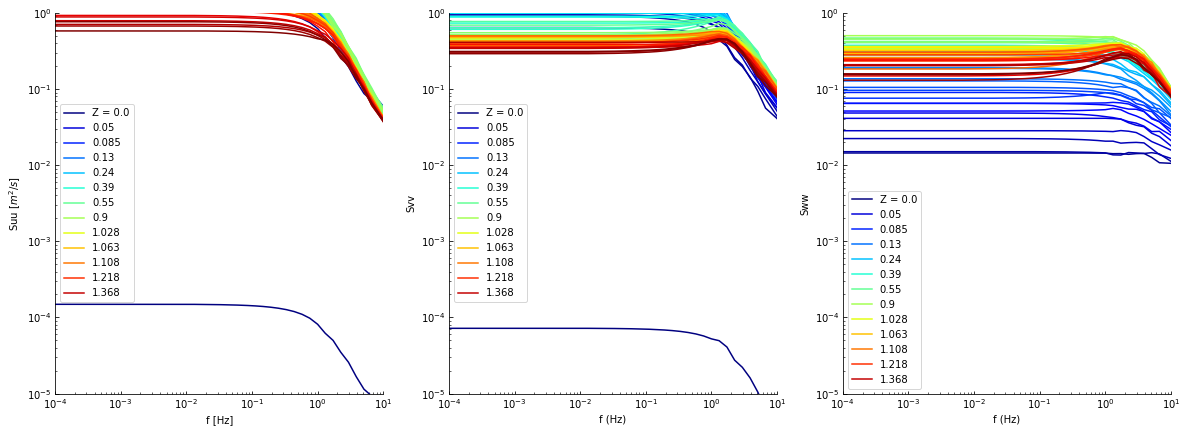

In [34]:
def commonSettings(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in',which='both')
    ax.set_xlim([1e-4, 10])
    ax.set_ylim([1e-5, 1])


plt.figure(figsize=[20,7])

N = len(prof.Z)
colors = cm.jet(np.linspace(0, 1, N))
# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors, N=N)

# i = 0
# plt.loglog(freq_lf, Suu_lf[:,i],'-k.')
# plt.loglog(freq_hf, Suu_hf[:,i],'-r.')

ax = plt.subplot(1,3,1)
lns = []
for i in range(N):
    if i%5 == 0:
        lbl = 'Z = '+str(np.round(prof.Z[i],3)) if len(lns) == 0 else str(np.round(prof.Z[i],3))
        ln, = plt.loglog(freq, Suu_2[:,i],'-',color=colors[i],label=lbl)
        lns.append(ln)
    else:
        plt.loglog(freq, Suu_2[:,i],'-',color=colors[i],label=str(np.round(prof.Z[i],3)))
commonSettings(ax)
plt.xlabel(r'f [Hz]')
plt.ylabel(r'Suu $[m^2/s]$')
plt.legend(handles=lns)

ax = plt.subplot(1,3,2)
lns = []
for i in range(N):
    if i%5 == 0:
        lbl = 'Z = '+str(np.round(prof.Z[i],3)) if len(lns) == 0 else str(np.round(prof.Z[i],3))
        ln, = plt.loglog(freq, Svv_2[:,i],'-',color=colors[i],label=lbl)
        lns.append(ln)
    else:
        plt.loglog(freq, Svv_2[:,i],'-',color=colors[i],label=str(np.round(prof.Z[i],3)))
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Svv')
plt.legend(handles=lns)


ax = plt.subplot(1,3,3)
lns = []
for i in range(N):
    if i%5 == 0:
        lbl = 'Z = '+str(np.round(prof.Z[i],3)) if len(lns) == 0 else str(np.round(prof.Z[i],3))
        ln, = plt.loglog(freq, Sww_2[:,i],'-',color=colors[i],label=lbl)
        lns.append(ln)
    else:
        plt.loglog(freq, Sww_2[:,i],'-',color=colors[i],label=str(np.round(prof.Z[i],3)))
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Sww')
plt.legend(handles=lns)

plt.show()

## DFSR Trial 2: scaled from Trial 1

Observations from Trial 1:
* $^xL_u$ is greatly underestimated. $^xL_v$ and $^xL_w$ are also slightly underestimated.
* Duration plays important role to match TI.

## Write to file

In [35]:
outdir = inflowDir_E2+'/input_v2/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

print(f"writing to: {outdir}")
prof2.to_csv(outdir+'profile',sep=' ',index=None,header=None)

temp = pd.DataFrame(prof.Z.tolist())
temp.to_csv(outdir+'spect_z',sep=' ',index=None,header=None)

temp = pd.DataFrame(freq.tolist())
temp.to_csv(outdir+'spect_f',sep=' ',index=None,header=None)

temp = pd.DataFrame(Suu_2)
temp.to_csv(outdir+'Suu',sep=' ',index=None,header=None)
temp = pd.DataFrame(Svv_2)
temp.to_csv(outdir+'Svv',sep=' ',index=None,header=None)
temp = pd.DataFrame(Sww_2)
temp.to_csv(outdir+'Sww',sep=' ',index=None,header=None)

with open(outdir+'samplingPoints', 'a') as the_file:
    the_file.write(str(len(prof.Z))+'\n(\n')
    for z in prof.Z:
        the_file.write('(0.0 0.0 '+str(z)+')\n')
    the_file.write(');\n')

writing to: D:/tempData_depot/simData_CandC/wt_tngE2/inflow//input_v2/


## DFSR output

In [36]:
sampleName = 'sampledData_inflow2.3'
readFromFile = False
if readFromFile:
    probes, time, UofT = foam.__readProbe_singleT(inflowDir_E2+sampleName+'/Ux','p')
    print('Finished reading UofT')
    _, _, VofT = foam.__readProbe_singleT(inflowDir_E2+sampleName+'/Uy','p')
    print('Finished reading VofT')
    _, _, WofT = foam.__readProbe_singleT(inflowDir_E2+sampleName+'/Uz','p')
    print('Finished reading WofT')

    UofT = np.transpose(UofT)
    VofT = np.transpose(VofT)
    WofT = np.transpose(WofT)

    np.save(inflowDir_E2+sampleName+'/time.npy',time)
    np.save(inflowDir_E2+sampleName+'/probes.npy',probes)
    np.save(inflowDir_E2+sampleName+'/UofT.npy',UofT)
    np.save(inflowDir_E2+sampleName+'/VofT.npy',VofT)
    np.save(inflowDir_E2+sampleName+'/WofT.npy',WofT)
else:
    time = np.load(inflowDir_E2+sampleName+'/time.npy')
    probes = np.load(inflowDir_E2+sampleName+'/probes.npy')
    UofT = np.load(inflowDir_E2+sampleName+'/UofT.npy')
    VofT = np.load(inflowDir_E2+sampleName+'/VofT.npy')
    WofT = np.load(inflowDir_E2+sampleName+'/WofT.npy')

dt = time[2] - time[1]

dfsr_E2_v2 = wind.profile(name="DFSR-E2-v2", Z=probes[:,2], UofT=UofT, VofT=VofT, WofT=WofT, H=H, dt=dt, nSpectAvg=32)

vel_E2 = wind.Profiles([wtVel_E2, dfsr_E2, dfsr_E2_v2])

Finished reading UofT
Finished reading VofT
Finished reading WofT


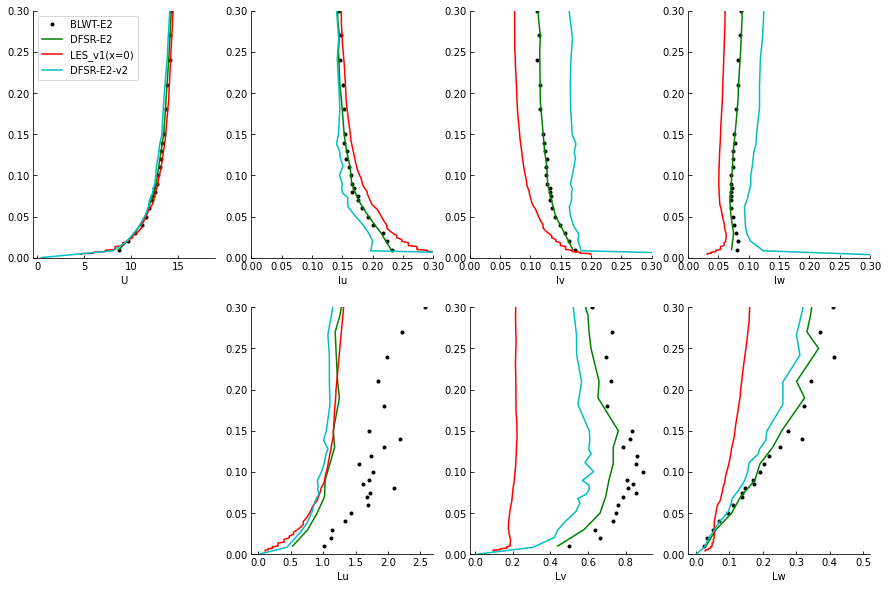

In [40]:
plotProfiles(wind.Profiles([wtVel_E2, dfsr_E2,les_x0, dfsr_E2_v2]), zMax=0.3, TIlim=[0,.3],
             col=['k','g','r','c'],
             mrk=['.','None','None','None'],
             lst=['None','-','-','-'])


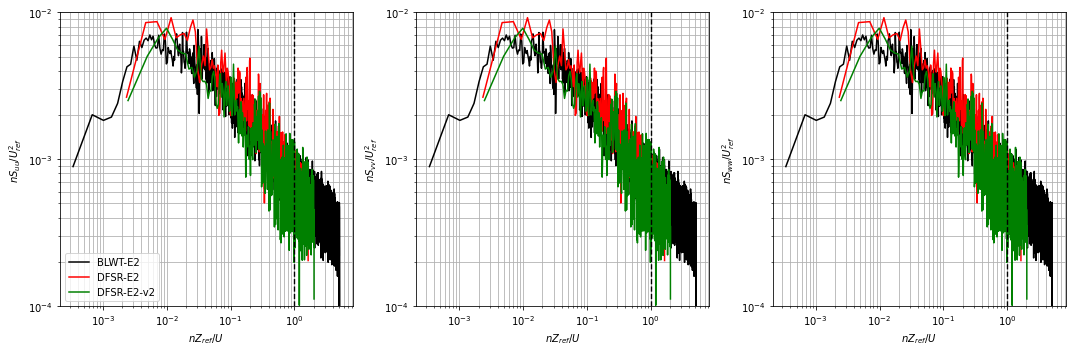

In [43]:
vel_E2.plotSpectra(yLimits=[[1e-4,1e-2],[1e-4,1e-2],[1e-4,1e-2]])

## Empty domain outputs

In [ ]:
lesDir = dir_wtVl_tngE2 + 'tngE2.2/'

les = []

# probeName = 'sampler.zProfile_x-3.5Hy0.probes'
# les_1 = foam.processVelProfile(lesDir,probeName=probeName,name="LES_v1(x=-3.5H)",exportPlots=False, trimTimeSegs=[[0,1.0]],H=H)
# les.append(les_1)

probeName = 'sampler.zProfile_x0y0.probes'
les2_x0 = foam.processVelProfile(lesDir,probeName=probeName,name="LES_v2(x=0)",exportPlots=False, trimTimeSegs=[[0,1.0]],H=H)
les.append(les2_x0)


In [ ]:
les2_x0.nSpectAvg = 32
les2_x0.Update()

In [ ]:
plotProfiles(wind.Profiles([wtVel_E2, dfsr_E2, les_x0, dfsr_E2_v2, les2_x0]), zMax=0.5,
             col=['k','g','r','c','r'],
             mrk=['.','None','None','None','None'],
             lst=['None','-','-','-','--'])

In [ ]:
def commonSettings(ax, zMax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in',which='both')
    ax.set_ylim([0, zMax])

def plotProfiles(wtVel_E2, prof, dfsr_E2, les, zMax = 0.5):


    plt.figure(figsize=[15,10])

    ax = plt.subplot(2,4,1)
    plt.plot(wtVel_E2.U, wtVel_E2.Z, '.k', label=wtVel_E2.name)
    plt.plot(prof.U, prof.Z, '-k', label='WT (smooth)')
    plt.plot(dfsr_E2.U, dfsr_E2.Z, '-g.', label=dfsr_E2.name)
    for l in les:
        plt.plot(l.U, l.Z, '-', label=l.name)
    plt.xlabel('U')
    plt.legend()
    commonSettings(ax, zMax)

    ax = plt.subplot(2,4,2)
    plt.plot(wtVel_E2.Iu, wtVel_E2.Z, '.k', label=wtVel_E2.name)
    plt.plot(prof.Iu, prof.Z, '-k', label='WT (smooth)')
    plt.plot(dfsr_E2.Iu, dfsr_E2.Z, '-g.', label=dfsr_E2.name)
    for l in les:
        plt.plot(l.Iu, l.Z, '-', label=l.name)
    plt.xlabel('Iu')
    commonSettings(ax, zMax)

    ax = plt.subplot(2,4,3)
    plt.plot(wtVel_E2.Iv, wtVel_E2.Z, '.k', label=wtVel_E2.name)
    plt.plot(prof.Iv, prof.Z, '-k', label='WT (smooth)')
    plt.plot(dfsr_E2.Iv, dfsr_E2.Z, '-g.', label=dfsr_E2.name)
    for l in les:
        plt.plot(l.Iv, l.Z, '-', label=l.name)
    plt.xlabel('Iv')
    commonSettings(ax, zMax)

    ax = plt.subplot(2,4,4)
    plt.plot(wtVel_E2.Iw, wtVel_E2.Z, '.k', label=wtVel_E2.name)
    plt.plot(prof.Iw, prof.Z, '-k', label='WT (smooth)')
    plt.plot(dfsr_E2.Iw, dfsr_E2.Z, '-g.', label=dfsr_E2.name)
    for l in les:
        plt.plot(l.Iw, l.Z, '-', label=l.name)
    plt.xlabel('Iw')
    commonSettings(ax, zMax)

    # ax = plt.subplot(2,4,5)
    # plt.plot(wtVel_E2.uv, wtVel_E2.Z, '.k', label=wtVel_E2.name)
    # # plt.plot(prof.Iw, prof.Z, '-k', label='WT (smooth)')
    # plt.plot(dfsr_E2.uv, dfsr_E2.Z, '-r.', label='DFSR')
    # plt.xlabel("u'w'")
    # commonSettings(ax)

    ax = plt.subplot(2,4,6)
    plt.plot(wtVel_E2.xLu, wtVel_E2.Z, '.k', label=wtVel_E2.name)
    plt.plot(prof.Lu, prof.Z, '-k', label='WT (smooth)')
    plt.plot(dfsr_E2.xLu, dfsr_E2.Z, '-g.', label=dfsr_E2.name)
    for l in les:
        plt.plot(l.xLu, l.Z, '-', label=l.name)
    plt.xlabel('Lu')
    commonSettings(ax, zMax)

    ax = plt.subplot(2,4,7)
    plt.plot(wtVel_E2.xLv, wtVel_E2.Z, '.k', label=wtVel_E2.name)
    plt.plot(prof.Lv, prof.Z, '-k', label='WT (smooth)')
    plt.plot(dfsr_E2.xLv, dfsr_E2.Z, '-g.', label=dfsr_E2.name)
    for l in les:
        plt.plot(l.xLv, l.Z, '-', label=l.name)
    plt.xlabel('Lv')
    commonSettings(ax, zMax)

    ax = plt.subplot(2,4,8)
    plt.plot(wtVel_E2.xLw, wtVel_E2.Z, '.k', label=wtVel_E2.name)
    plt.plot(prof.Lw, prof.Z, '-k', label='WT (smooth)')
    plt.plot(dfsr_E2.xLw, dfsr_E2.Z, '-g.', label=dfsr_E2.name)
    for l in les:
        plt.plot(l.xLw, l.Z, '-', label=l.name)
    plt.xlabel('Lw')
    commonSettings(ax, zMax)

    plt.show()

In [ ]:
plotProfiles(wtVel_E2,prof, les2_x0,les, zMax=0.3)

In [ ]:
les2_x0.SpectH.nSpectAvg = 16
les2_x0.SpectH.Update()
les = [les2_x0]

In [ ]:
def commonSettings(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in',which='both')
    ax.set_xlim([1e-3, 1e3])
    ax.set_ylim([1e-5, 1e1])

plt.figure(figsize=[20,6])

N = len(prof.Z)
colors = cm.jet(np.linspace(0, 1, N))
# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors, N=N)



ax = plt.subplot(1,3,1)
plt.loglog(wtVel_E2.SpectH.n, wtVel_E2.SpectH.Suu, '.k-', label='WT')
plt.loglog(dfsr_E2.SpectH.n, dfsr_E2.SpectH.Suu, '.g-', label='DFSR')
for l in les:
    plt.loglog(l.SpectH.n, l.SpectH.Suu, '.-', label=l.name)
commonSettings(ax)
plt.xlabel(r'f [Hz]')
plt.ylabel(r'Suu $[m^2/s]$')
plt.legend()

ax = plt.subplot(1,3,2)
plt.loglog(wtVel_E2.SpectH.n, wtVel_E2.SpectH.Svv, '.k-')
plt.loglog(dfsr_E2.SpectH.n, dfsr_E2.SpectH.Svv, '.g-')
for l in les:
    plt.loglog(l.SpectH.n, l.SpectH.Svv, '.-', label=l.name)
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Svv')

ax = plt.subplot(1,3,3)
plt.loglog(wtVel_E2.SpectH.n, wtVel_E2.SpectH.Sww, '.k-')
plt.loglog(dfsr_E2.SpectH.n, dfsr_E2.SpectH.Sww, '.g-')
for l in les:
    plt.loglog(l.SpectH.n, l.SpectH.Sww, '.-', label=l.name)
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Sww')

plt.show()

In [ ]:
rSuu = wtVel_E2.SpectH.rf()
print(np.shape(rSuu))

In [ ]:
def commonSettings(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in',which='both')
    ax.set_xlim([1e-4, 10])
    ax.set_ylim([1e-5, 0.1])

plt.figure(figsize=[20,6])

N = len(prof.Z)
colors = cm.jet(np.linspace(0, 1, N))
# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors, N=N)



ax = plt.subplot(1,3,1)
plt.loglog(wtVel_E2.SpectH.rf(), wtVel_E2.SpectH.rSuu(), '.k', label='WT')
plt.loglog(dfsr_E2.SpectH.rf(), dfsr_E2.SpectH.rSuu(), '.g', label='DFSR')
for l in les:
    plt.loglog(l.SpectH.rf(), l.SpectH.rSuu(), '.-', label=l.name)
commonSettings(ax)
plt.xlabel(r'$nH/U_h$')
plt.ylabel(r'$nS_{uu}/\sigma_u^2$')
plt.legend()

ax = plt.subplot(1,3,2)
plt.loglog(wtVel_E2.SpectH.rf(), wtVel_E2.SpectH.rSvv(), '.k')
plt.loglog(dfsr_E2.SpectH.rf(), dfsr_E2.SpectH.rSvv(), '.g')
for l in les:
    plt.loglog(l.SpectH.rf(), l.SpectH.rSvv(), '.-', label=l.name)
commonSettings(ax)
plt.xlabel(r'$nH/U_h$')
plt.ylabel(r'$nS_{vv}/\sigma_v^2$')

ax = plt.subplot(1,3,3)
plt.loglog(wtVel_E2.SpectH.rf(), wtVel_E2.SpectH.rSww(), '.k')
plt.loglog(dfsr_E2.SpectH.rf(), dfsr_E2.SpectH.rSww(), '.g')
for l in les:
    plt.loglog(l.SpectH.rf(), l.SpectH.rSww(), '.-', label=l.name)
commonSettings(ax)
plt.xlabel(r'$nH/U_h$')
plt.ylabel(r'$nS_{ww}/\sigma_w^2$')

plt.show()

Trial 2: scaled from Trial 1

Observations from Trial 1:
* $v$ and $w$ components of both TI and integral length scales are significantly decayed.
* The fetch distance has the most effect on $I_w$ close to the ground
* A slight overestimation of $I_u$ around to roof-height ($z=H=0.08m$).

Changes in Trial 2:
* Scale up $I_u$, $I_v$, $I_w$, $^xL_u$, $^xL_v$, $^xL_w$ with the ratio between the final LES output and the original BLWT input.

## DFSR

Observations from Trial 1:
* $^xL_u$ is greatly underestimated. $^xL_v$ and $^xL_w$ are also slightly underestimated.
* Duration plays important role to match TI.

In [ ]:

plotProfiles(wtVel_E2,prof, dfsr_E2,les, zMax=1.5)


In [ ]:
eIdx = np.argmin(np.abs(prof.Z - les_x0.Z[-1])) -2

prof_les = prof.copy()
prof_les.U  = np.interp(prof_les.Z, les_x0.Z, les_x0.U)
prof_les.Iu = np.interp(prof_les.Z, les_x0.Z, les_x0.Iu)
prof_les.Iv = np.interp(prof_les.Z, les_x0.Z, les_x0.Iv)
prof_les.Iw = np.interp(prof_les.Z, les_x0.Z, les_x0.Iw)
prof_les.Lu = np.interp(prof_les.Z, les_x0.Z, les_x0.xLu)
prof_les.Lv = np.interp(prof_les.Z, les_x0.Z, les_x0.xLv)
prof_les.Lw = np.interp(prof_les.Z, les_x0.Z, les_x0.xLw)

sclFctr_1 = prof.copy()
sclFctr_1.loc[:, ~sclFctr_1.columns.isin(['Z'])] = 1.0

prof2 = prof.copy()

clmns = ['U', 'Iu', 'Iv', 'Iw', 'Lu', 'Lv', 'Lw']
for c in clmns:
    sclFctr_1.loc[:eIdx, c] = prof.loc[:eIdx, c] / prof_les.loc[:eIdx, c]
    sclFctr_1.loc[eIdx:, c] = sclFctr_1.loc[eIdx, c]
    prof2.loc[:,c] = smooth((prof.loc[:,c] * sclFctr_1.loc[:,c]), 5, 4)

plt.figure()
plt.plot(les_x0.xLv, les_x0.Z, '.r-', label='LES')
plt.plot(prof.Lv, prof.Z, '.g-', label='target-1')
plt.plot(prof2.Lv, prof2.Z, '.b-', label='target-2')
plt.legend()
plt.ylim([0, 1.8])